In [3]:
# !pip install qiskit
# !pip install pylatexenc
# !pip install matplotlib-venn
# !pip install -U -r resources/requirements.txt

import qiskit
print("Qiskit:",qiskit.__qiskit_version__)
from qiskit import *
from qiskit.quantum_info import Statevector 
# from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
from qiskit.visualization import plot_histogram

# find the least busy backend 
# provider = IBMQ.get_provider(hub='ibm-q')
from qiskit.providers.ibmq import least_busy
# backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 2 and
#                                    not b.configuration().simulator and b.status().operational==True))
# job_exp = execute(circuit, backend=backend, shots=1024)
from qiskit.tools.monitor import job_monitor
# job_monitor(job_exp)  # displays job status under cell

from IPython.display import clear_output
clear_output()
from qiskit import Aer
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
import numpy as np
from IPython.display import clear_output
clear_output()
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
import tensorflow as tf
import matplotlib.pyplot as plt 
from tensorflow.image import ResizeMethod
from scipy import optimize


In [12]:
def evolution(input_dim,reference_dim,thetas,phis,lambdas):
  classical_qubit = ClassicalRegister(1)    ### for swap test
  swap_test_qubit = QuantumRegister(1)      ### for swap test
  input = QuantumRegister(input_dim)
  reference_state = QuantumRegister(reference_dim)

  #intializing circuit
  qc = QuantumCircuit(classical_qubit, swap_test_qubit, reference_state, input)

  para_index=0
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  qc.barrier()
  
  for i in range(0,input_dim):
    for j in range(0,input_dim):
      if j!=i:
        qc.cu3(thetas[para_index],phis[para_index],lambdas[para_index], input[i], input[j])
        para_index+=1
  qc.barrier()  
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  ###SWAP test for measuring fidelity
  qc.barrier()
  qc.h(swap_test_qubit)
  for i in range(reference_dim):
    qc.cswap(swap_test_qubit,input[i],reference_state[i])
  qc.h(swap_test_qubit)
  # qc.measure(swap_test_qubit,classical_qubit)
  return qc 

In [7]:
mnist = tf.keras.datasets.mnist # Object of the MNIST dataset
np.random.seed(77)
(x_train, y_train),(x_test, y_test) = mnist.load_data() # Load data
X_batch=tf.reshape(x_train, [-1, 28, 28, 1])

####downscale to 16x16 and convert to blackwhite
h_dim=16
v_dim=16
abc=tf.image.resize(  
    X_batch, [h_dim,v_dim], method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)

nclasses = np.unique(y_train).size
threshold = 125
def shapex(X):
    return np.where(X<127,0,1)
x_train = np.squeeze(shapex(abc),-1)




11493376/11490434 [==============================] - 0s 0us/step


(60000, 16, 16)


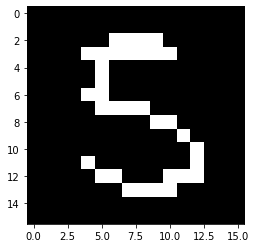

In [31]:
print(np.shape(x_train))
plt.imshow(x_train[2414], cmap="gray") # Import the image
plt.show() # Plot the image

In [10]:
def image_to_state_vector(x):
  ''' 16x16 BW image to normalized 256x1 vec
  '''
  state_vector=[]
  for row in x:
    for elt in row:
      state_vector.append(elt)
  return state_vector/np.linalg.norm(state_vector)

def get_init_state(init_sv):
  '''tensor product input with aiding qubits (reference state & swap_test_qubit)
  '''
  state=[]
  for i in range(2**(input_dim+reference_dim+1)):
    if i%(2**(reference_dim+1))==0:
      state.append(init_sv[i//2**(reference_dim+1)])
    else:
      state.append(0)
  state=Statevector(state)
  return state

###get input batch
state_input_batchs = [image_to_state_vector(x) for x in x_train]

# input_dim=8
# reference_dim=2
# thetas = [0]*(input_dim*(input_dim-1)+2*input_dim)
# phis = [0]*(input_dim*(input_dim-1)+2*input_dim)
# lambdas = [0]*(input_dim*(input_dim-1)+2*input_dim)
# mnistU=evolution(input_dim,reference_dim,thetas,phis,lambdas)
# mnistU.draw('mpl',scale=0.5)

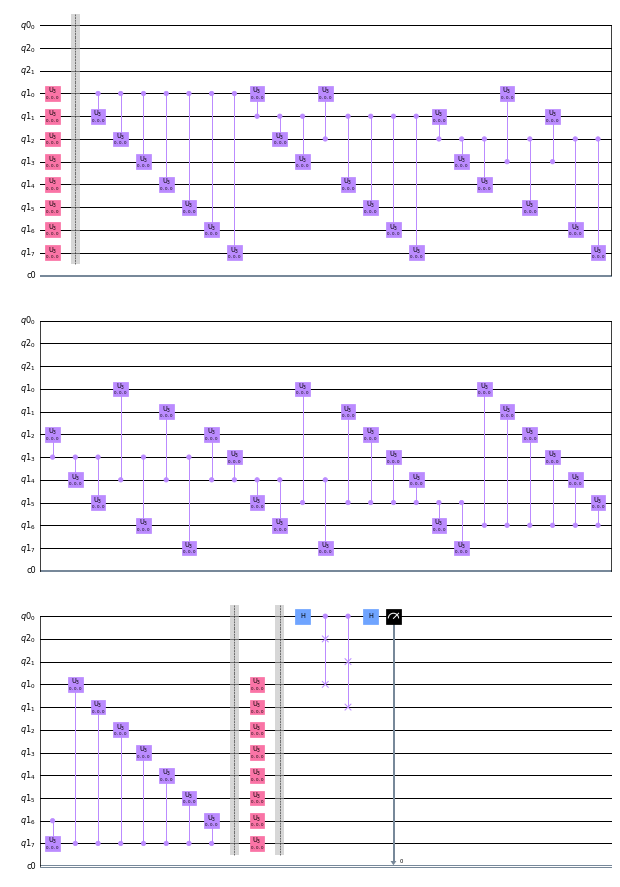

In [ ]:
# np.shape(state_input_batchs[:1000])
# z=get_init_state(state_input_batchs[0])
# final_state=z.evolve(mnistU)
# qiskit.quantum_info.partial_trace(final_state,range(1,input_dim+reference_dim+1))

In [20]:
def calculate_fidelity(x0,training_inputs):
  x0=np.reshape(x0,(3,-1))
  thetas = x0[0]
  phis = x0[1]
  lambdas = x0[2]
  total_error = 0
  mnistU=evolution(input_dim,reference_dim,thetas,phis,lambdas)
  for input_sv in training_inputs:
    state=get_init_state(input_sv)
    final_state=state.evolve(mnistU)     ###evolution
    ##tracing over all except the swap_test_qubit
    p_0=qiskit.quantum_info.partial_trace(final_state,range(1,input_dim+reference_dim+1)).probabilities()[0]  
    # if p_0>1: print(p_0)
    fidel=np.sqrt(max(0,2*p_0-1))
    total_error +=(1-fidel)
  total_error /= training_inputs.shape[0]
  print("\b obj:",total_error)
  return total_error

In [21]:
input_dim=8
reference_dim=2
n_para = (input_dim*(input_dim-1)+2*input_dim)*3
dim_state = 2**input_dim
x0 = np.random.uniform(np.pi,np.pi*3,n_para)

In [30]:
minimizer_kwargs ={
    "method" : "L-BFGS-B",
    "args"   : np.array(state_input_batchs[:90]),
    "bounds" : optimize.Bounds(0,4*np.pi),
    "options": {"iprint" : 100, "maxls": 15, "disp": True}
}

In [32]:
# calculate_fidelity(x0, np.array(state_input_batchs[:1000]))
local_mins =[]

def record_local_mins(x,f,accept):
    local_mins.append((x,f))
    print("x:")
    print(x)
ret = optimize.basinhopping(calculate_fidelity, x0, minimizer_kwargs=minimizer_kwargs,
                   niter=30,disp=True,niter_success=10,callback=record_local_mins)

Streaming output truncated to the last 5000 lines.
 obj: 0.17774610571115287
 obj: 0.17774610570923116
 obj: 0.17774610571052715
 obj: 0.17774610570968544
 obj: 0.17774610571217203
 obj: 0.17774610571137803
 obj: 0.177746105710908
 obj: 0.1777461057116019
 obj: 0.17774610571096372
 obj: 0.17774610571160884
 obj: 0.1777461057083838
 obj: 0.17774610571122493
 obj: 0.1777461057101905
 obj: 0.1777461057141779
 obj: 0.1777461057109351
 obj: 0.17774610570826385
 obj: 0.17774610570937568
 obj: 0.17774610571052085
 obj: 0.17774610570773644
 obj: 0.17774610570809596
 obj: 0.17774610570869423
 obj: 0.17774610570972932
 obj: 0.17774610570874827
 obj: 0.17774610570937563
 obj: 0.17774610570937568
 obj: 0.17774610571232505
 obj: 0.17774610570933827
 obj: 0.17774610570814542
 obj: 0.17774610570978297
 obj: 0.17774610571151406
 obj: 0.17774610570937568
 obj: 0.17774610570937555
 obj: 0.17774610570937568
 obj: 0.1777461057095802
 obj: 0.17774610570959437
 obj: 0.177

KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).


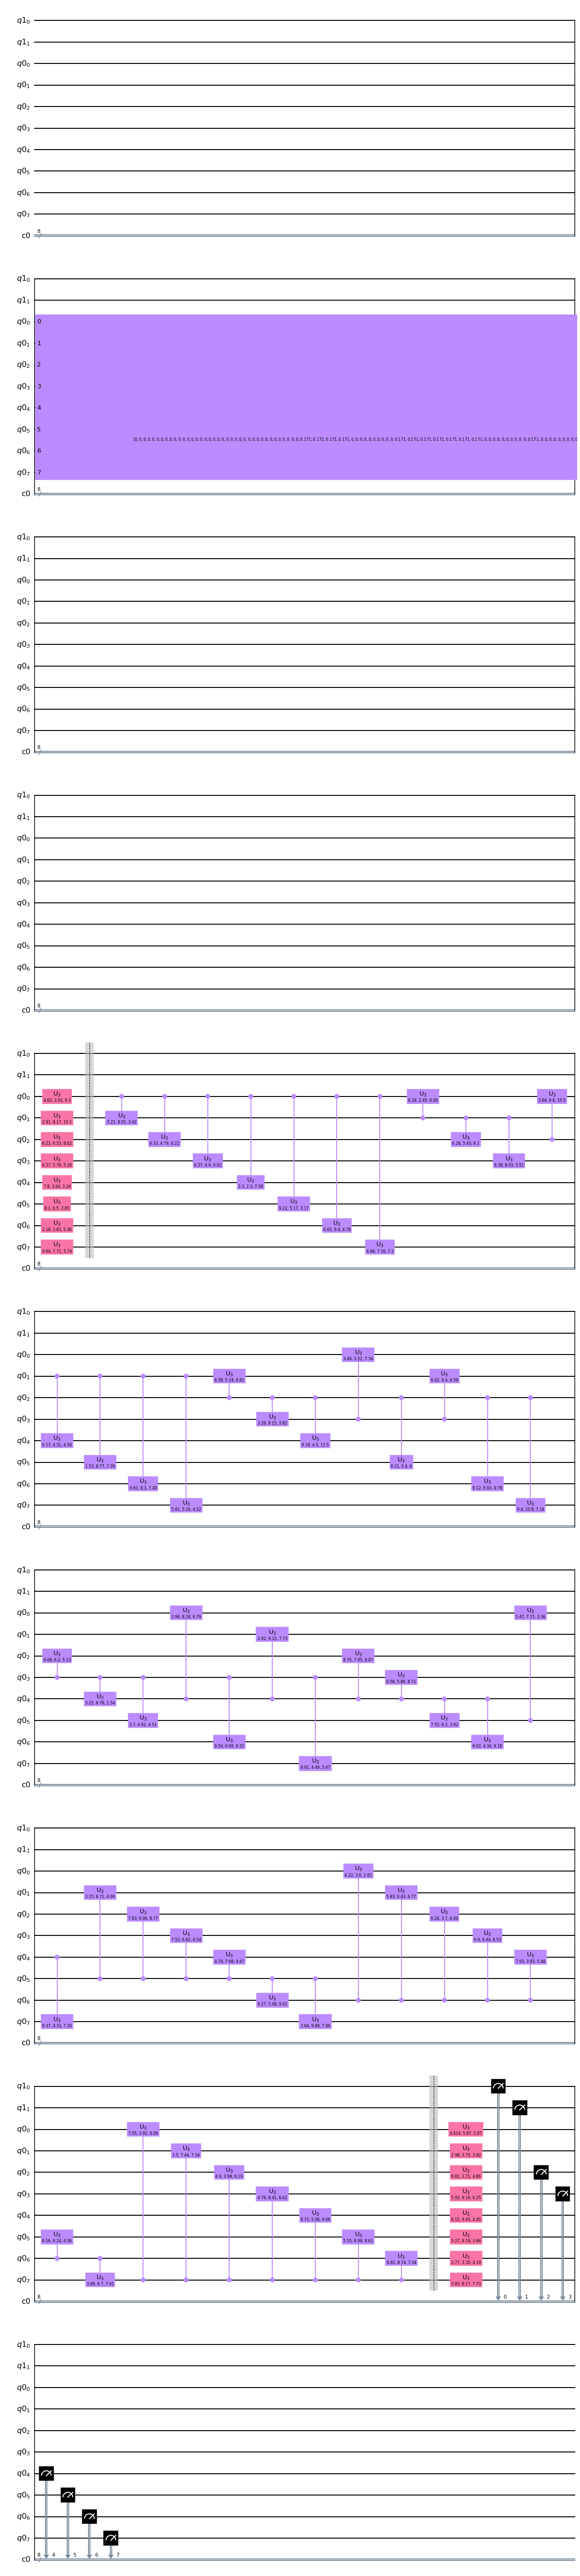

In [11]:
x0=[ 4.63377548,  2.91380008,  6.22067708,  6.36816439 , 7.80257465 , 8.1007036, 3.18021723,  9.64087525,  5.21070101 , 6.32675336 , 6.37293117 , 3.29680539
    ,9.21799296,  6.64710154 , 6.67534848 , 6.17659396 , 6.27695603 , 6.38004265,6.17141852,  1.52626093 , 9.61475831 , 5.80939447 , 3.644797   , 6.58223162
    ,3.28394932,  9.18293924 , 9.20651627 , 9.11714953 , 9.40242496 , 3.48637658,6.01581743,  9.0846855  , 3.25377434 , 3.70023503 , 9.04353391 , 8.90528873,
    2.9575088 ,  2.92499841 , 8.7516528  , 6.55758975 , 7.52396734 , 6.02925922, 9.37103051,  5.47255006 , 3.15258975 , 7.63414475 , 7.51868501 , 4.74300066,
    6.26762641,  3.63839055 , 6.22485317 , 5.83363357 , 6.26382188 , 6.89603043, 7.93344061,  6.15527778 , 3.69130815 , 7.05365086 , 3.49616931 , 6.89529795,
    4.79061882,  6.70528814 , 5.5474148  , 6.81457214 , 0.41365876 , 2.98241622, 6.81438946,  5.9153262  , 6.14656508 , 5.27232257 , 2.76778422 , 3.84796497,
    3.9277979 ,  8.16764322 , 6.52890507 , 5.75583801 , 3.63511912 , 6.50017381,3.83431501,  7.71425835 , 8.00698766 , 4.78736469 , 4.90074736 , 2.30302932,
    5.16859469,  9.40450947 , 7.15881863 , 2.44880574 , 5.42908394 , 8.03236061, 4.30522631,  8.77315712 , 8.30276412 , 5.16150204 , 9.60090526 , 5.24382052,
    8.15024387,  4.49563119 , 5.39677028 , 6.92980402 ,10.80943617 , 3.52446029, 9.40203408,  6.20323043 , 8.77664041 , 4.91595529 , 6.68539952  ,4.49457124,
    8.26176873,  9.14950594 , 7.94596361 , 5.86391198 , 6.20400044 , 4.34275983, 4.331633  ,  7.15360477 , 6.70772603 , 9.0600109  , 6.82301224 , 7.67572338,
    5.07670436,  9.88408009 , 3.6024647  , 6.4347754  , 3.70083809 , 6.43501013, 3.93482012 , 9.23696284 , 6.69683152 , 3.91668669  ,7.43661417 , 3.97587222,
    8.41287941 , 5.05775929 , 6.97831217 , 8.73713493 , 5.86739235 , 3.74803101, 3.71409142 , 6.16133947 , 9.45346995 , 8.19466202 , 3.35178947 , 8.16673683,
    9.30248777 ,10.07791612 , 8.62102806 , 5.25918244  ,3.24142464 , 3.84544272, 5.36380526 , 5.73889473 , 3.42121233 , 6.22099087 , 9.03154812 , 7.582466,
    3.16684308 , 4.77891297 , 7.20171717 , 6.0557084  , 6.10321291 , 3.5101247, 4.5754093  , 7.3885371  , 7.49342969 , 4.52269851 ,10.52461017 , 9.80738428,
    3.82371505 ,11.5019492  , 6.00351722 , 9.77971463 , 7.1755479  , 7.33655606, 6.5943811  , 5.12920917 , 1.54376867 , 4.52102659 , 9.3226428  , 5.67260608,
    6.79039066 , 7.73348102 , 8.87395517 , 8.71029593 , 3.92291478 , 9.17803617, 7.25980849 , 3.35933131 , 4.08955688 , 8.7668718  , 6.54133426 , 4.46692004,
    9.00908024 , 7.85803686 , 2.65395314 , 6.76836585 , 6.04467026 , 6.52802814,5.47883088 , 4.36038993 , 7.91073658 , 6.08792806 , 7.34207872 , 6.19413542,
    6.62223122 , 6.65916537 , 8.60714225 , 7.33847489 , 5.86666914 , 3.82142952, 4.86204114 , 6.24911558 , 4.45280229  ,3.6592454  , 4.18999654 , 7.73014235]
input_dim=8
reference_dim=2
x0=np.reshape(x0,(3,-1))
thetas = x0[0]
phis = x0[1]
lambdas = x0[2]
init_state=state_input_batchs[2414]
# state=get_init_state(state_input_batchs[2414])
# final_state=state.evolve(mnistU)

def trained_circuit(init_state,input_dim,reference_dim,thetas,phis,lambdas):
  classical_qubit = ClassicalRegister(input_dim)    ### for swap test
  input = QuantumRegister(input_dim)
  reference_state = QuantumRegister(reference_dim)

  #intializing circuit
  qc = QuantumCircuit(classical_qubit, reference_state, input)
  qc.initialize(init_state,input)

  para_index=0
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  qc.barrier()
  
  for i in range(0,input_dim):
    for j in range(0,input_dim):
      if j!=i:
        qc.cu3(thetas[para_index],phis[para_index],lambdas[para_index], input[i], input[j])
        para_index+=1
  qc.barrier()  
  for i in range(input_dim):
    qc.u3(thetas[para_index],phis[para_index],lambdas[para_index], input[i])
    para_index+=1
  
  output=list(range(0,reference_dim))+list(range(2*reference_dim,reference_dim+input_dim))
  qc.measure(output,classical_qubit)
  return qc 

circuit=trained_circuit(init_state,input_dim,reference_dim,thetas,phis,lambdas)
circuit.draw('mpl')

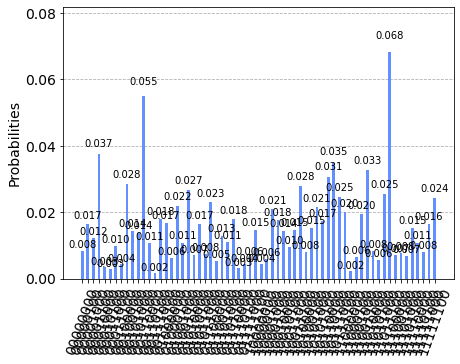

In [13]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(circuit, backend=simulator, shots=100000).result().get_counts(circuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)


In [23]:
p=np.zeros(256)
for key,count in counts.items():
  p[int(key, 2)]=count/100000



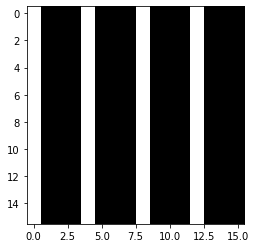

In [30]:
XX=np.where(p<1/10000,0,1)
plt.imshow(XX.reshape(16,16), cmap="gray") # Import the image
plt.show() # Plot the image


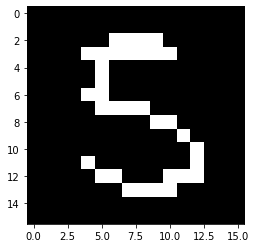